In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tensorflow.keras as keras
from tqdm import tqdm

W1210 21:30:45.548882 140544940951360 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
W1210 21:30:45.549983 140544940951360 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
W1210 21:30:45.550724 140544940951360 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
W1210 21:30:45.551260 140544940951360 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Read Dataset

In [4]:
import pandas as pd

# base_path = '/opt/shared-disk2/'
base_path = '/mnt/large-disk/'
# base_path = '/home/ccchen/sychou/labs/lab13-2/'
captcha_dir = 'words_captcha/'
full_path = base_path + captcha_dir
anno = 'spec_train_val.txt'

def convert2path(img):
    return full_path + img + '.png'

def convert2caption(caption_str):
    return '<start> ' + ' '.join(str(caption_str)) + ' <end>'

spec = pd.read_csv(full_path + anno, header=None, delim_whitespace=True, names=['image', 'caption'])
test_list = pd.read_csv(full_path + anno, header=None, delim_whitespace=True, names=['image', 'caption'])
spec['image'] = spec['image'].apply(convert2path)
spec['caption'] = spec['caption'].apply(convert2caption)

display(spec.head())

# Select the first 100,000 captions from the shuffled set
num_examples = 120000
num_train = 100000
num_val = 20000

all_captions = spec['caption'].to_numpy()
all_img_name_vector = spec['image'].to_numpy()

print(f"Path: {full_path}")

display(all_captions[:5])
display(all_img_name_vector[:5])

,image,caption
0,/mnt/large-disk/words_captcha/a0.png,<start> t h u s <end>
1,/mnt/large-disk/words_captcha/a1.png,<start> w w w <end>
2,/mnt/large-disk/words_captcha/a2.png,<start> t i e d <end>
3,/mnt/large-disk/words_captcha/a3.png,<start> i d s <end>
4,/mnt/large-disk/words_captcha/a4.png,<start> j a m <end>


Path: /mnt/large-disk/words_captcha/


array(['<start> t h u s <end>', '<start> w w w <end>',
       '<start> t i e d <end>', '<start> i d s <end>',
       '<start> j a m <end>'], dtype=object)

array(['/mnt/large-disk/words_captcha/a0.png',
       '/mnt/large-disk/words_captcha/a1.png',
       '/mnt/large-disk/words_captcha/a2.png',
       '/mnt/large-disk/words_captcha/a3.png',
       '/mnt/large-disk/words_captcha/a4.png'], dtype=object)

In [5]:
def map_load_image(image_path, cap):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 224))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, cap

In [6]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [7]:
display(all_captions[:5])

array(['<start> t h u s <end>', '<start> w w w <end>',
       '<start> t i e d <end>', '<start> i d s <end>',
       '<start> j a m <end>'], dtype=object)

In [8]:
# Choose the top 5000 words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower = False,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)
train_seqs = tokenizer.texts_to_sequences(all_captions)

In [9]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [10]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(all_captions)

In [11]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [12]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [13]:
# Split Train / Validation
img_name_train = all_img_name_vector[:num_train]
img_name_val = all_img_name_vector[num_train:num_examples]
img_name_test = all_img_name_vector[num_examples:]
cap_train = cap_vector[:num_train]
cap_val = cap_vector[num_train:num_examples]
cap_test = cap_vector[num_examples:]

display(img_name_train[:5])
display(cap_train[:5])

display([[tokenizer.index_word[i] for i in word] for word in cap_train[:5]])
# for word in cap_train[:5]:
#     print(word) 
#     for i in word:
#         print(tokenizer.index_word[i])

array(['/mnt/large-disk/words_captcha/a0.png',
       '/mnt/large-disk/words_captcha/a1.png',
       '/mnt/large-disk/words_captcha/a2.png',
       '/mnt/large-disk/words_captcha/a3.png',
       '/mnt/large-disk/words_captcha/a4.png'], dtype=object)

array([[ 1,  8, 17, 16,  5,  2,  0],
       [ 1, 23, 23, 23,  2,  0,  0],
       [ 1,  8,  7,  3, 12,  2,  0],
       [ 1,  7, 12,  5,  2,  0,  0],
       [ 1, 25,  4, 15,  2,  0,  0]], dtype=int32)

[['<start>', 't', 'h', 'u', 's', '<end>', '<pad>'],
 ['<start>', 'w', 'w', 'w', '<end>', '<pad>', '<pad>'],
 ['<start>', 't', 'i', 'e', 'd', '<end>', '<pad>'],
 ['<start>', 'i', 'd', 's', '<end>', '<pad>', '<pad>'],
 ['<start>', 'j', 'a', 'm', '<end>', '<pad>', '<pad>']]

In [14]:
img_name_train.shape, cap_train.shape, img_name_val.shape, cap_val.shape, img_name_test.shape, cap_test.shape

((100000,), (100000, 7), (20000,), (20000, 7), (0,), (0, 7))

## Create a tf.data dataset for training
I set the batch size as 16 since I've tried 100, 40 and 80 batch size and the losses go down too slowly. Batch with 16 images performs much better.

In [15]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 5000
embedding_dim = 224
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))
dataset = dataset.map(map_load_image, 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model
Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [17]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Encoder Model
Here I use VGG16 with some modification. First, reshape the output of the last convolution layer into (49, 512) and it speed up the training massively(loss reduce to 0.06 in 3 epochs) rather than the original flatten layer. However, I don't know why. Then, after the reshaping, it connects to a dense layer of 1000 units. It also reduce the loss.

In [18]:
input_1 = tf.keras.Input(shape=(224,224,3))

x = keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same')(input_1)

x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(64,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
        
x = keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(128,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
        
x = keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(256,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

x = keras.layers.Conv2D(512,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(512,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(512,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

x = keras.layers.Conv2D(512,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(512,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(512,(3,3),strides=(1,1),padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

x = keras.layers.Reshape((-1, x.shape[3]))(x)
# x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1000, activation='relu')(x)
output_1 = keras.layers.Dense(embedding_dim,activation='relu')(x)

encoder = keras.Model(input_1, output_1)

In [19]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856 

In [20]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [21]:
# encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

Here I reduce the learning rate to reduce the fluctuation of the loss value

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoint
It would restore the training status back to last state.

In [23]:
checkpoint_path = "/mnt/large-disk/sychou/checkpoints/train/cs2"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=150)

In [24]:
start_epoch = 0
latest = ckpt_manager.latest_checkpoint
if latest:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(latest)
    ckpt.restore(latest)
# start_epoch = 9
# ckpt.restore('/mnt/large-disk/sychou/checkpoints/train/cs2/ckpt-9')

/mnt/large-disk/sychou/checkpoints/train/cs2/ckpt-25


## Training
You extract the features stored in the respective .npy files and then pass those features through the encoder.
The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
The decoder returns the predictions and the decoder hidden state.
The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
Use teacher forcing to decide the next input to the decoder.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [25]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [26]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        # print(f"Target: {target.shape}")

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Due to lack of time, I load the trained model of last time. The Loss Plot doesn't show anything.

In [27]:
EPOCHS = 26

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    print(f'Epoch {epoch + 1}')
    for (batch, (img_tensor, target)) in enumerate(tqdm(dataset)):
        # print(total_loss)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        # print(img_tensor[0].shape)

        # if batch % 100 == 0:
        #     print ('Epoch {} Batch {} Loss {:.4f}'.format(
        #       epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

0it [00:00, ?it/s]Epoch 26
6250it [11:12,  9.30it/s]
Epoch 26 Loss 0.001774
Time taken for 1 epoch 672.3826978206635 sec



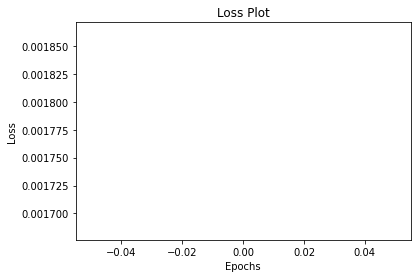

In [28]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!
The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
Stop predicting when the model predicts the end token.
And store the attention weights for every time step.

In [29]:
model_epoch = 0
latest = ckpt_manager.latest_checkpoint
if latest:
    model_epoch = int(latest.split('-')[-1])
    print(latest)
    ckpt.restore(latest)

/mnt/large-disk/sychou/checkpoints/train/cs2/ckpt-26


In [30]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    img_tensor_val = tf.expand_dims(load_image(image), 0)
    # img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    is_end = False

    for i in range(max_length):
        if is_end:
            result.append(tokenizer.index_word[0])
        else:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            predicted_id = tf.argmax(predictions[0]).numpy()
            result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            # return result, attention_plot
            is_end = True

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [31]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    # fig = plt.figure(figsize=(10, 10))

    # len_result = len(result)
    # for l in range(len_result):
    #     temp_att = np.resize(attention_plot[l], (8, 8))
    #     ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    #     ax.set_title(result[l])
    #     img = ax.imshow(temp_image)
    #     ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [32]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    return img

Real Caption: <start> m y s q l <end>
Prediction Caption: m y s q l <end> <pad>


<Figure size 432x288 with 0 Axes>

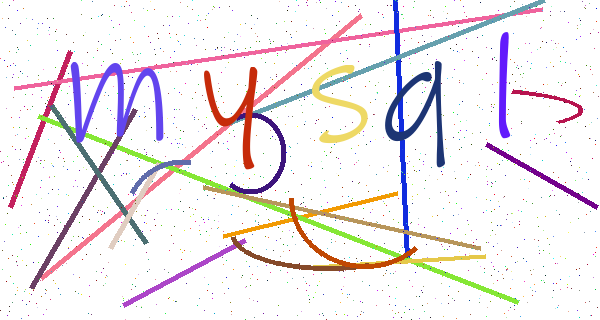

In [33]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

# Test on validation set & output prediction

In [34]:
def predict(image):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = tf.expand_dims(load_image(image), 0)
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
    return result

def filter_tag(letter):
    tags = ['<start>', '<end>', '<pad>']
    if letter in tags:
        return False
    else:
        return True

In [35]:
acc_num = 0
pbar = tqdm(range(len(img_name_val)))
for rid in pbar:
    image = img_name_val[rid]
    # print(f"Path: {image}")
    real_caption = [tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]
    pred_caption = predict(image)

    real_caption = list(filter(filter_tag, real_caption))
    pred_caption = list(filter(filter_tag, pred_caption))
    # print(f"Real: {real_caption}, Pred: {pred_caption}")
    if real_caption == pred_caption:
        acc_num = acc_num + 1
    else:
        pass
        # print(f"Real: {real_caption}, Pred: {pred_caption}")
    pbar.set_description(f"Acc: {round((acc_num / (rid+1)) * 100, 2)}%")

print(f"Total Acc: {round((acc_num / len(img_name_val)) * 100, 2)}%")

Acc: 96.55%: 100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [18:49<00:00, 17.70it/s]Total Acc: 96.55%



In [67]:
from os import listdir
from os.path import isfile, join

file_list = [f for f in listdir(full_path) if isfile(join(full_path, f)) and f[-4:] == '.png']
test_full_path_list = [join(full_path, f) for f in file_list if isfile(join(full_path, f)) and int(f[1:-4]) >= num_examples]
test_name_list = [f[:-4] for f in file_list if isfile(join(full_path, f)) and int(f[1:-4]) >= num_examples]
print(len(test_full_path_list))
print(len(test_file_list))
print(test_full_path_list[:5])
print(test_name_list[:5])

20000
20000
['/mnt/large-disk/words_captcha/a135084.png', '/mnt/large-disk/words_captcha/a125297.png', '/mnt/large-disk/words_captcha/a124189.png', '/mnt/large-disk/words_captcha/a132933.png', '/mnt/large-disk/words_captcha/a126946.png']
['a135084', 'a125297', 'a124189', 'a132933', 'a126946']


In [68]:
import csv
pbar = tqdm(range(len(test_full_path_list)))

with open('./labs/lab13-2/output/Lab13-2_106033233.txt', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile, delimiter=' ')

  for rid in pbar:
      image = test_full_path_list[rid]
      pred_caption = predict(image)
      
      pred_caption = ''.join(list(filter(filter_tag, pred_caption)))
      row = [test_name_list[rid], pred_caption]

    #   print(row)
      writer.writerow(row)


100%|████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [18:10<00:00, 18.35it/s]
